

## *ZERBO Zoumana ISE2                                                       ENSAE 2024-2025*


# EXERCICE 1

Analyser les variables explicatives: que constatez vous entre le jeu de train et le jeu de test?


In [26]:
# chargement des librairies
from pathlib import Path
import matplotlib.pyplot as plt #Visualisation
import missingno as msno #visuation des missing
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
#from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot

# Chargement de la base de donnée

In [4]:
# lien vers la base de données
# Return a new path pointing to the current working directory
data_link = "https://raw.githubusercontent.com/MouslyDiaw/tp-supervised-learning/refs/heads/master/billets.csv"

# importation de la base
#you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv(data_link, sep=";")
data.shape  # data frame dimensions (nb rows, nb columns)


(1500, 7)

# Modelisation

In [22]:
import warnings
warnings.filterwarnings('default')
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

In [6]:
#filtre les lignes de data où la colonne margin_low n'est pas nulle
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

#fournit un résumé des informations de data_model
data_model.info()

# Création des variables explicatives et cible:
# X est la liste des variables explicatives et y est la variable cible
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]  # ou data.drop(["margin_low", "is_genuine"], axis=1)
y = data_model.loc[:, 'margin_low']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


# Données d'entraînement/ Données de test

In [7]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


# Standardisation

In [8]:
# Standardisons les données :

std_scaler = StandardScaler().fit(X_train)  # Standardize features by removing the mean and scaling to unit variance.
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Fonction d'entrainement

In [9]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    mse_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    mse_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(mse_test, 5)}")
    return {"estimator": model, "mse_train": mse_train, "mse_test": mse_test}


## Elastic net

In [10]:
# Train and evaluate ridge regression
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Model error: 0.42698


C:\Users\HP\Anaconda3\a\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


# ANALYSE

Pour analyser les différences entre le jeu d’entraînement et le jeu de test dans le cadre d’une régression Elastic Net, il est important de comparer les distributions des variables explicatives entre les deux ensembles de données. Cela permet de vérifier si les caractéristiques sont bien alignées ou si des divergences significatives peuvent influencer la performance et la généralisation du modèle.

## Comparons les statistiques descriptives des variables explicatives dans les jeux de train et de test

In [11]:
# Exemple de comparaison des statistiques descriptives
train_stats = X_train.describe()
test_stats = X_test.describe()
print("Statistiques descriptives du jeu d'entraînement:\n", train_stats)
print("Statistiques descriptives du jeu de test:\n", test_stats)

Statistiques descriptives du jeu d'entraînement:
           diagonal  height_left  height_right    margin_up       length
count  1024.000000  1024.000000   1024.000000  1024.000000  1024.000000
mean    171.962383   104.035996    103.921045     3.157305   112.675596
std       0.301231     0.300359      0.326683     0.230871     0.873045
min     171.050000   103.220000    102.910000     2.560000   109.970000
25%     171.750000   103.827500    103.700000     2.990000   112.045000
50%     171.960000   104.040000    103.920000     3.140000   112.950000
75%     172.180000   104.240000    104.160000     3.310000   113.332500
max     172.890000   104.880000    104.950000     3.910000   114.320000
Statistiques descriptives du jeu de test:
          diagonal  height_left  height_right   margin_up      length
count  439.000000   439.000000    439.000000  439.000000  439.000000
mean   171.951754   104.020456    103.922483    3.143235  112.672802
std      0.315320     0.297897      0.318636    0.23

# Analyse des statistiques descriptives

Les statistiques descriptives des jeux d'entraînement et de test sont globalement très similaires, ce qui est une bonne nouvelle pour l'entraînement et l'évaluation de votre modèle. Les moyennes, écarts-types, quartiles, et les valeurs minimales et maximales ne montrent pas de différences significatives entre les deux ensembles de données. Cela suggère que vos jeux de données sont bien équilibrés et que le modèle devrait être capable de généraliser sans trop de risque de sur-ajustement.

Cependant, même si les statistiques sont proches, il peut être utile de réaliser des tests plus approfondis, comme la vérification de la distribution exacte (par exemple avec des tests de normalité ou des histogrammes) pour confirmer qu'il n'y a pas de différences subtiles dans les distributions qui pourraient affecter la performance du modèle.

## Visualisation

In [27]:
#import warnings
#!pip install seaborn --upgrade

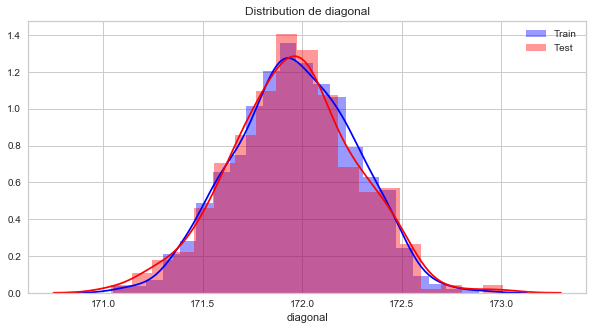

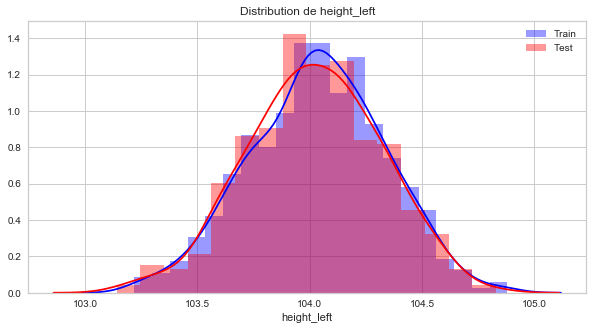

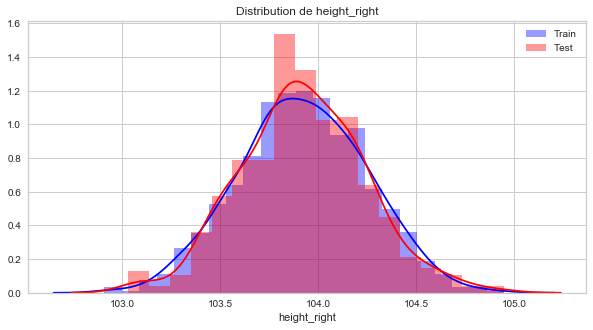

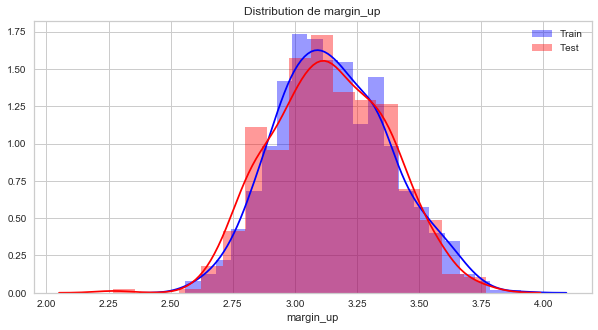

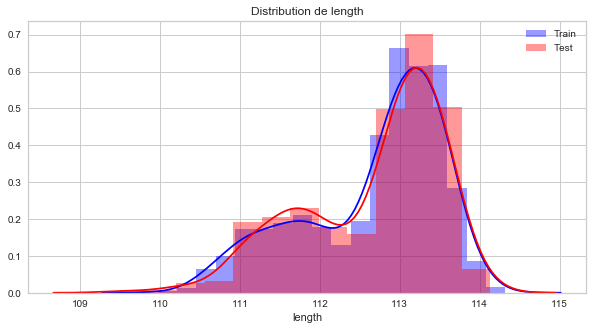

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns  # Correction ici, importation correcte de seaborn

for column in X_train.columns:
    plt.figure(figsize=(10, 5))
    sns.distplot(X_train[column], color='blue', kde=True, label='Train')
    sns.distplot(X_test[column], color='red', kde=True, label='Test')
    plt.title(f"Distribution de {column}")
    plt.legend()
    plt.show()



# Analyse des graphes

En résumé, les graphiques de distribution obtenus sont cohérents avec les statistiques descriptives calculées plus haut. Les distributions etant effectivement similaires pour chaque varaible, cela confirmera que les données d'entraînement et de test sont bien réparties et que le modèle ne devrait pas rencontrer de problèmes liés à des biais entre les ensembles.

# Évaluons le degré de corrélation entre les variables explicatives

In [19]:
train_corr = X_train.corr()
test_corr = X_test.corr()
print("Corrélation des variables dans le jeu d'entraînement:\n", train_corr)
print("Corrélation des variables dans le jeu de test:\n", test_corr)


Corrélation des variables dans le jeu d'entraînement:
               diagonal  height_left  height_right  margin_up    length
diagonal      1.000000     0.010229     -0.029736  -0.050775  0.077258
height_left   0.010229     1.000000      0.234991   0.276457 -0.328110
height_right -0.029736     0.234991      1.000000   0.295909 -0.386754
margin_up    -0.050775     0.276457      0.295909   1.000000 -0.534437
length        0.077258    -0.328110     -0.386754  -0.534437  1.000000
Corrélation des variables dans le jeu de test:
               diagonal  height_left  height_right  margin_up    length
diagonal      1.000000     0.035154      0.004217  -0.079225  0.153130
height_left   0.035154     1.000000      0.235888   0.165936 -0.282413
height_right  0.004217     0.235888      1.000000   0.333605 -0.446241
margin_up    -0.079225     0.165936      0.333605   1.000000 -0.491210
length        0.153130    -0.282413     -0.446241  -0.491210  1.000000


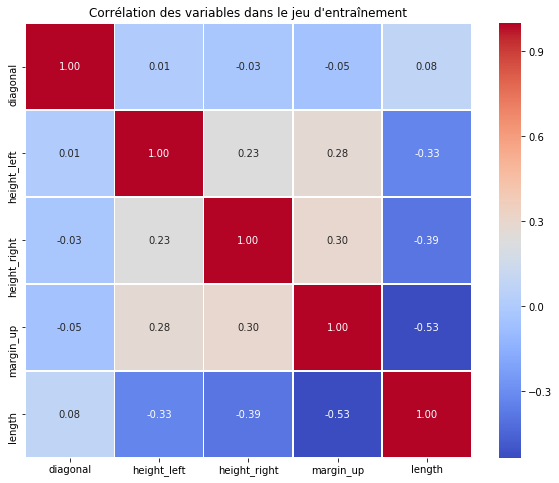

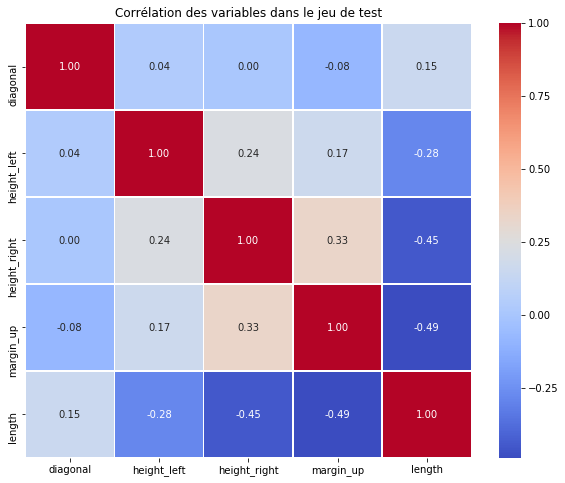

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de corrélation pour le jeu d'entraînement
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Corrélation des variables dans le jeu d'entraînement")
plt.show()

# Matrice de corrélation pour le jeu de test
plt.figure(figsize=(10, 8))
sns.heatmap(test_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Corrélation des variables dans le jeu de test")
plt.show()


# Analyse de la correlation

Les corrélations modérées entre certaines variables, notamment entre margin_up et length, ainsi qu'entre height_left et height_right, pourraient influencer les performances des modèles de régression linéaire ou des modèles basés sur des relations linéaires. Ces corrélations sont toutefois relativement faibles, ce qui laisse supposer que les variables sont assez indépendantes. Il sera important de tester la multicolinéarité dans les modèles, mais il n'y a pas de signes d’une forte interdépendance.

# EXERCICE 2

In [11]:
# chargement des librairies
from pathlib import Path
import matplotlib.pyplot as plt #Visualisation
import missingno as msno #visuation des missing
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


In [13]:
# lien vers la base de données
# Return a new path pointing to the current working directory
data_link = "https://raw.githubusercontent.com/MouslyDiaw/tp-supervised-learning/refs/heads/master/billets.csv"


In [15]:
# importation de la base
#you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv(data_link, sep=";")
data.shape  # data frame dimensions (nb rows, nb columns)

(1500, 7)

## Modelisation

In [18]:
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

In [20]:
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [22]:
# Création des variables explicatives et cible:
# X est la liste des variables explicatives et y est la variable cible
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]  # ou data.drop(["margin_low", "is_genuine"], axis=1)
y = data_model.loc[:, 'margin_low']

# Jeu d'entraînement VS Jeu de test

In [25]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


# Standardisation

In [28]:
# Standardisons les données :

std_scaler = StandardScaler().fit(X_train)  # Standardize features by removing the mean and scaling to unit variance.
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Ridge

In [31]:
# On crée un modèle de régression linéaire
ridge = linear_model.Ridge(alpha=1.)

# On entraîne ce modèle sur les données d'entrainement
ridge.fit(X_train, y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test
ridge_error = np.mean((ridge.predict(X_test) - y_test) ** 2)


# On obtient l'erreur quadratique ci-dessous
print(ridge_error)

0.2162136226425013


# Ridge optimisé

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Définir la plage de valeurs pour alpha dans le modèle Ridge
ridge_params = {'alpha': np.logspace(-4, 4, 100)}

# Initialiser le modèle Ridge
ridge_model = Ridge()

# Configurer GridSearchCV pour le modèle Ridge
ridge_search = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_squared_error', cv=5)

# Effectuer la recherche par grille pour le modèle Ridge
ridge_search.fit(X_train, y_train)

# Afficher le meilleur paramètre alpha et l'erreur quadratique minimale obtenue
print("Ridge Regression - Meilleur alpha :", ridge_search.best_params_)
print("Erreur quadratique minimale (MSE) :", -ridge_search.best_score_)

# Entraîner le modèle final Ridge avec les meilleurs paramètres trouvés
best_ridge = ridge_search.best_estimator_

# Calculer et afficher l'erreur sur les données de test
ridge_test_error = mean_squared_error(y_test, best_ridge.predict(X_test))
print("Erreur de test Ridge :", ridge_test_error)


Ridge Regression - Meilleur alpha : {'alpha': 10.235310218990268}
Erreur quadratique minimale (MSE) : 0.24030231959087972
Erreur de test Ridge : 0.2161286013671876


Ridge Regression - Meilleur alpha : {'alpha': 10.235310218990268}
Erreur quadratique minimale (MSE) : 0.24030231959087972


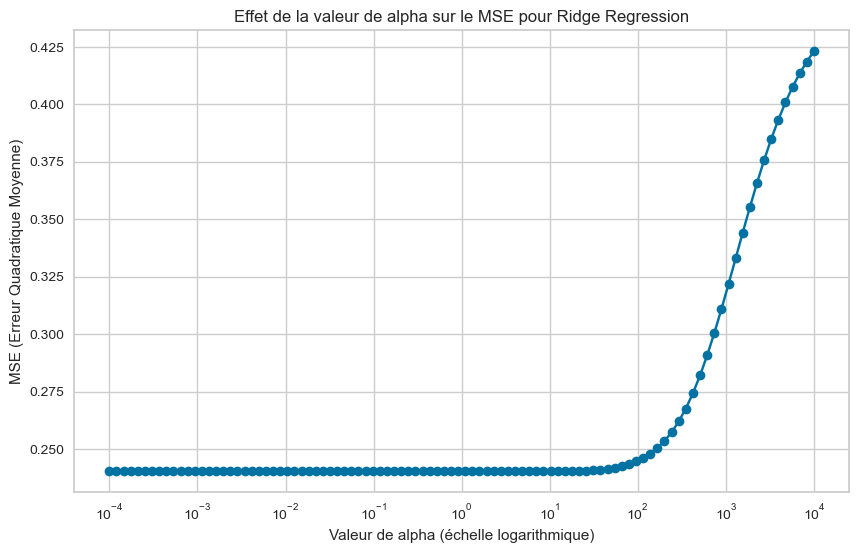

Erreur de test Ridge : 0.2161286013671876


In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

# Définir la plage de valeurs pour alpha dans le modèle Ridge
ridge_params = {'alpha': np.logspace(-4, 4, 100)}

# Initialiser le modèle Ridge
ridge_model = Ridge()

# Configurer GridSearchCV pour le modèle Ridge
ridge_search = GridSearchCV(ridge_model, ridge_params, scoring='neg_mean_squared_error', cv=5)

# Effectuer la recherche par grille pour le modèle Ridge
ridge_search.fit(X_train, y_train)

# Extraire les résultats de la recherche par grille
alphas = ridge_search.cv_results_['param_alpha'].data
mean_mse_scores = -ridge_search.cv_results_['mean_test_score']

# Afficher le meilleur paramètre alpha et l'erreur quadratique minimale obtenue
print("Ridge Regression - Meilleur alpha :", ridge_search.best_params_)
print("Erreur quadratique minimale (MSE) :", -ridge_search.best_score_)

# Courbe des valeurs d'alpha en fonction du MSE
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_mse_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Valeur de alpha (échelle logarithmique)')
plt.ylabel('MSE (Erreur Quadratique Moyenne)')
plt.title('Effet de la valeur de alpha sur le MSE pour Ridge Regression')
plt.show()

# Calculer et afficher l'erreur sur les données de test avec le meilleur modèle
best_ridge = ridge_search.best_estimator_
ridge_test_error = mean_squared_error(y_test, best_ridge.predict(X_test))
print("Erreur de test Ridge :", ridge_test_error)


# Lasso

In [37]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

In [55]:
# Train and evaluate ridge regression
lasso_error = train_model(model=linear_model.Lasso(fit_intercept=True, alpha=1.,),
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

Model error: 0.42698


# Lasso optimisé

Lasso Regression - Meilleur alpha : {'alpha': 0.0001}
Erreur quadratique minimale (MSE) : 0.2395496570212526


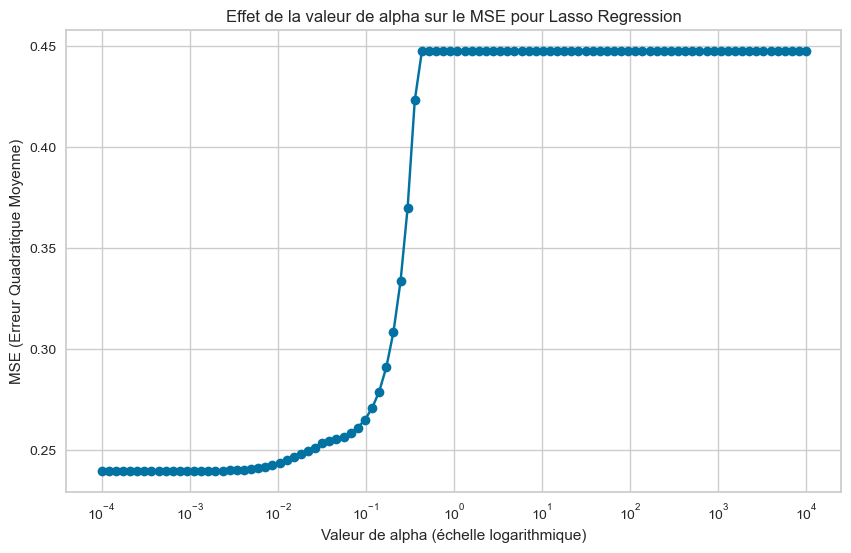

Erreur de test Lasso : 0.21624485583494807


In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Définir la plage de valeurs pour alpha dans le modèle Lasso
lasso_params = {'alpha': np.logspace(-4, 4, 100)}

# Initialiser le modèle Lasso
lasso_model = Lasso()

# Configurer GridSearchCV pour le modèle Lasso
lasso_search = GridSearchCV(lasso_model, lasso_params, scoring='neg_mean_squared_error', cv=10)

# Effectuer la recherche par grille pour le modèle Lasso
lasso_search.fit(X_train, y_train)

# Extraire les résultats de la recherche par grille
alphas = lasso_search.cv_results_['param_alpha'].data
mean_mse_scores = -lasso_search.cv_results_['mean_test_score']

# Afficher le meilleur paramètre alpha et l'erreur quadratique minimale obtenue
print("Lasso Regression - Meilleur alpha :", lasso_search.best_params_)
print("Erreur quadratique minimale (MSE) :", -lasso_search.best_score_)

# Courbe des valeurs d'alpha en fonction du MSE
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_mse_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Valeur de alpha (échelle logarithmique)')
plt.ylabel('MSE (Erreur Quadratique Moyenne)')
plt.title('Effet de la valeur de alpha sur le MSE pour Lasso Regression')
plt.show()

# Calculer et afficher l'erreur sur les données de test avec le meilleur modèle
best_lasso = lasso_search.best_estimator_
lasso_test_error = mean_squared_error(y_test, best_lasso.predict(X_test))
print("Erreur de test Lasso :", lasso_test_error)


# Elastic net

In [44]:
# Train and evaluate ridge regression
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Model error: 0.42698


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


Meilleur alpha : 0.013257113655901081
Meilleur l1_ratio : 0.0
Erreur quadratique minimale (MSE) sur validation croisée : 0.24030461323915803


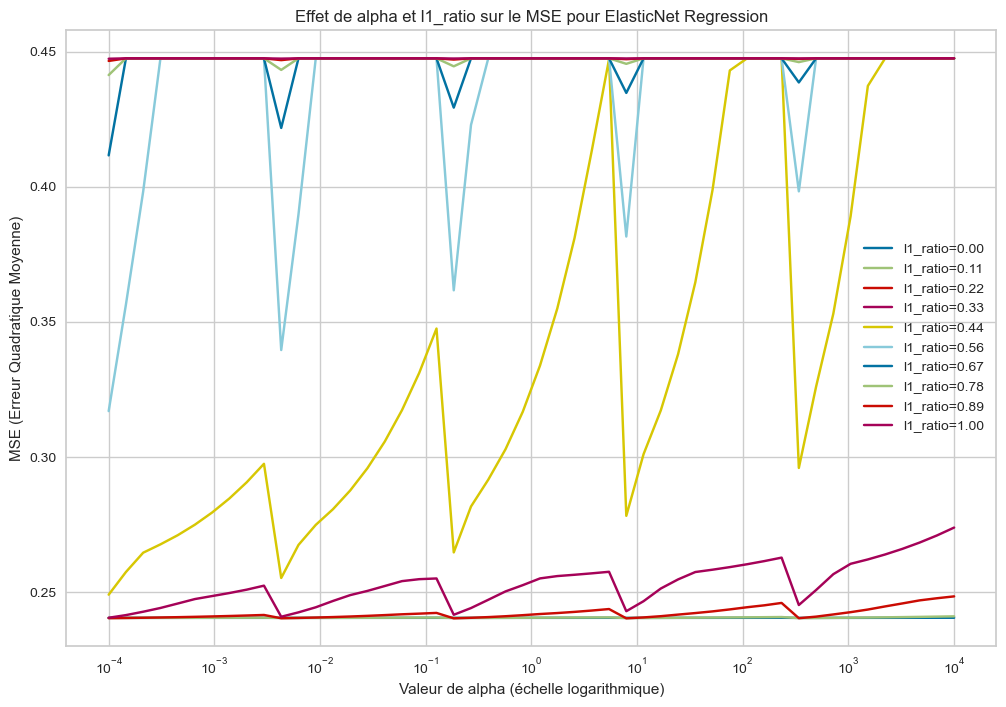

In [51]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning

# Ignorer les UserWarning et ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialiser le modèle ElasticNet
elastic_net = linear_model.ElasticNet()

# Définir les grilles de paramètres pour alpha et l1_ratio
param_grid = {
    'alpha': np.logspace(-4, 4, 50),  # 50 valeurs de alpha entre 10^-4 et 10^4
    'l1_ratio': np.linspace(0, 1, 10) # 10 valeurs de l1_ratio entre 0 et 1
}

# Configurer la recherche en grille avec validation croisée
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Récupérer les meilleurs paramètres et le modèle optimal
best_elasticnet = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_error = -grid_search.best_score_

# Afficher les meilleurs paramètres et l'erreur correspondante
print(f"Meilleur alpha : {best_alpha}")
print(f"Meilleur l1_ratio : {best_l1_ratio}")
print(f"Erreur quadratique minimale (MSE) sur validation croisée : {best_error}")

# Afficher la variation de l'erreur en fonction de alpha et l1_ratio
mean_test_errors = -grid_search.cv_results_['mean_test_score']
alpha_values = param_grid['alpha']

plt.figure(figsize=(12, 8))
for idx, l1_ratio in enumerate(param_grid['l1_ratio']):
    plt.plot(alpha_values, mean_test_errors[idx*len(alpha_values):(idx+1)*len(alpha_values)], label=f'l1_ratio={l1_ratio:.2f}')

plt.xscale('log')
plt.xlabel('Valeur de alpha (échelle logarithmique)')
plt.ylabel('MSE (Erreur Quadratique Moyenne)')
plt.title('Effet de alpha et l1_ratio sur le MSE pour ElasticNet Regression')
plt.legend()
plt.show()



Importance des variables pour le modèle Ridge Regression :
        Feature  Importance
4        length   -0.409387
2  height_right    0.244336
3     margin_up    0.244044
1   height_left    0.167290
0      diagonal   -0.080171


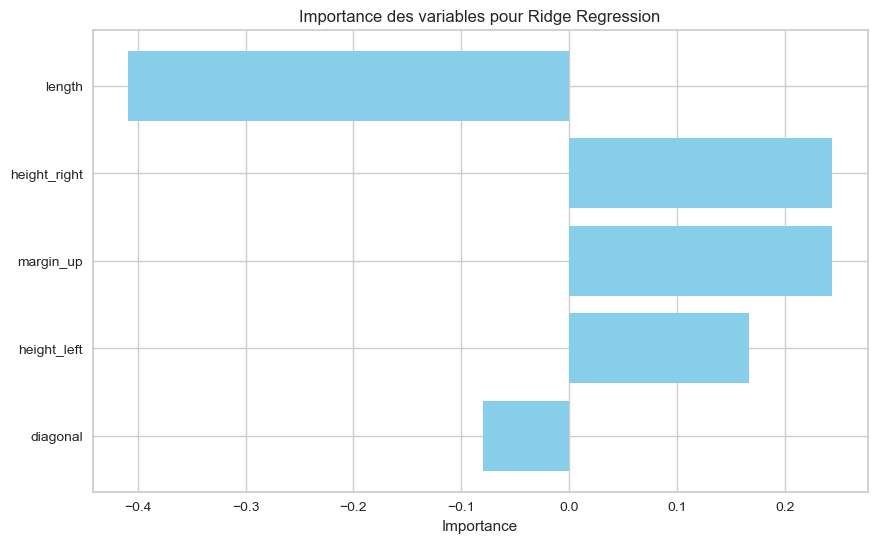


Importance des variables pour le modèle Lasso Regression :
        Feature  Importance
4        length   -0.405300
3     margin_up    0.286305
2  height_right    0.259675
1   height_left    0.175803
0      diagonal   -0.086771


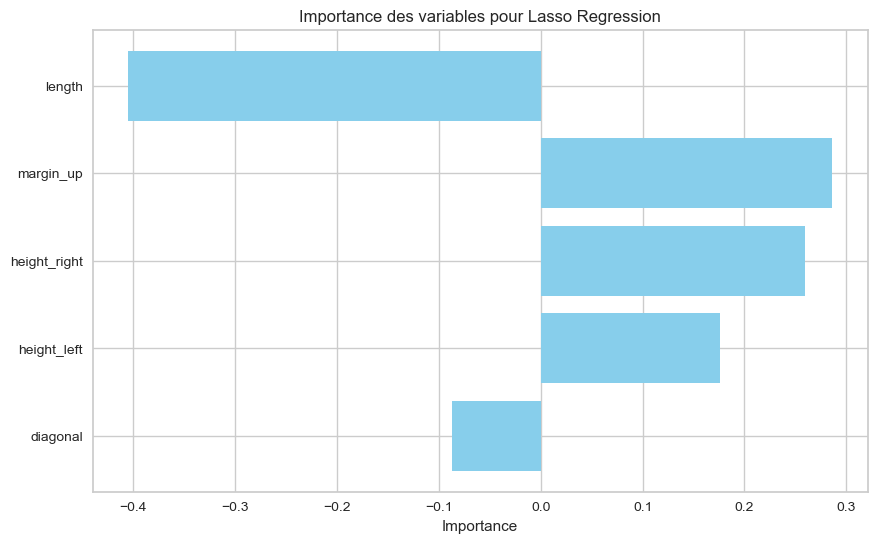


Importance des variables pour le modèle ElasticNet Regression :
        Feature  Importance
4        length   -0.410222
2  height_right    0.239536
3     margin_up    0.233293
1   height_left    0.164359
0      diagonal   -0.077965


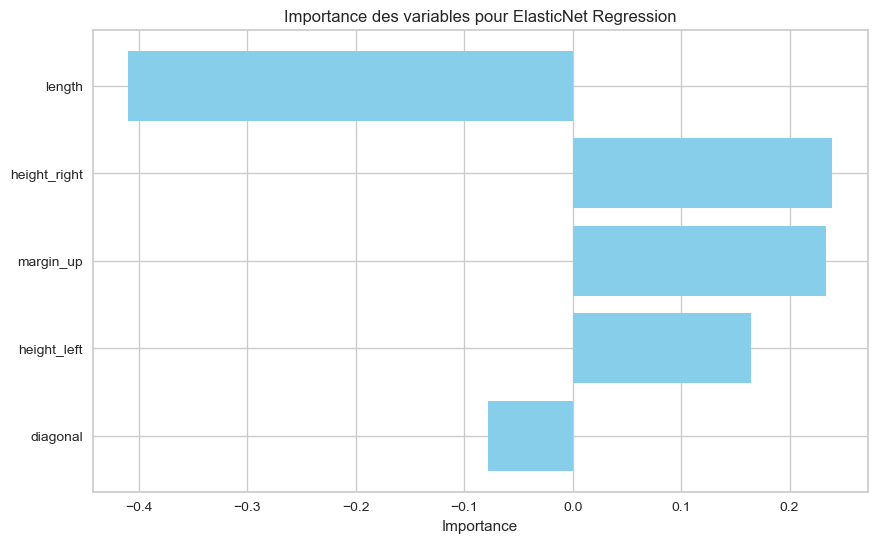

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Nom des variables d'entrée (X_train.columns si c'est un DataFrame)
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Fonction pour afficher les coefficients triés par importance avec un graphique
def display_feature_importance(model, model_name):
    coefficients = model.coef_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
    importance_df['Absolute Importance'] = importance_df['Importance'].abs()  # Pour trier par importance absolue
    importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)
    
    # Affichage des 10 variables les plus importantes
    top_features = importance_df.head(10)  # Modifier ce nombre pour afficher plus ou moins de variables
    
    # Affichage textuel des coefficients
    print(f"\nImportance des variables pour le modèle {model_name} :")
    print(top_features[['Feature', 'Importance']])
    
    # Graphique d'importance des variables
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Importance des variables pour {model_name}')
    plt.gca().invert_yaxis()  # Inverse l'ordre pour afficher la plus grande importance en haut
    plt.show()

# Afficher les importances des variables pour chaque modèle
display_feature_importance(best_ridge, "Ridge Regression")
display_feature_importance(best_lasso, "Lasso Regression")
display_feature_importance(best_elasticnet, "ElasticNet Regression")
